# Imports and setup

In [1]:
from pysegmt_utils import *
import importlib

# workDir="/ChangLab5-hd2/hannah/data/TS16/"
# tomoFiles = list(glob(os.path.join(workDir,"*.hdf")))
# segFiles = list(glob(os.path.join(workDir,"*.pdb")))

# tomoFile = tomoFiles[0]
# segFile = segFiles[0]

# tomogram = getTomo(tomoFile)
# filaments = getSeg(segFile)
# filaments = list(segment.values())


In [3]:
# tag = "TS16"
# workDir = os.path.join("/ChangLab5-hd2/hannah/data/",tag)
# segDir = os.path.join(workDir,"segmentations")
# tomoDir = os.path.join(workDir,"tomograms")

# tomoFiles = list(glob(os.path.join(tomoDir,"*preproc.hdf")))
# segFiles = list(glob(os.path.join(segDir,"*.cmm")))

# maskedTomogram, df = maskTomogram(tomoFiles[0], segFiles[0], suffix = "2022_05_12")

In [2]:
tag = "T_gondii/WT"
workDir = os.path.join("/ChangLab5-hd2/hannah/data/",tag)
segDir = os.path.join(workDir,"segmentations")
tomoDir = os.path.join(workDir,"tomograms")

tomoFiles = list(glob(os.path.join(tomoDir,"*preproc.hdf")))
preSegFiles = list(glob(os.path.join(segDir,"*.txt")))

tomoFile = os.path.join(tomoDir,"TS20_2_SIRT_filter_preproc.hdf")
segFile = os.path.join(segDir,"TS20_2_SIRT_filter_preproc.txt")

rOut = 540/(DEFAULT_APIX*DEFAULT_TOMOGRAMBIN)
rIn = 45/(DEFAULT_APIX*DEFAULT_TOMOGRAMBIN)
maskInner = False
nThreads = 14
suffix = "2022_05_17"
interp = True

In [5]:
# # get info
# if segFile.endswith('.pdb'):
#     filaments = PDB2Fil(segFile)
# elif segFile.endswith('.cmm'):
#     filaments = CMM2Fil(segFile)
# elif segFile.endswith('.txt'):
#     filaments = TXT2Fil(segFile)
# print("%d filaments" % len(filaments))
# tomogram = getTomo(tomoFile)
# # start calculation
# start_time=time.time()
# coords = inFilCoords(filaments, dim=tomogram.shape, rOut=rOut, rIn=rIn, maskInner=maskInner, nThreads=nThreads)
# time_elapsed = time.time() - start_time
# print("--- %s seconds ---\n" % (time_elapsed))

In [6]:
print("TOMOGRAM:\t"+tomoFile)
print("SEGMENTATION:\t"+segFile)

if segFile.endswith('.pdb'):
    filaments = PDB2Fil(segFile)
elif segFile.endswith('.cmm'):
    filaments = CMM2Fil(segFile)
elif segFile.endswith('.txt'):
    filaments = TXT2Fil(segFile)
# else:
#     return None
print("%d filaments" % len(filaments))

TOMOGRAM:	/ChangLab5-hd2/hannah/data/T_gondii/WT/tomograms/TS20_2_SIRT_filter_preproc.hdf
SEGMENTATION:	/ChangLab5-hd2/hannah/data/T_gondii/WT/segmentations/TS20_2_SIRT_filter_preproc.txt
2 filaments


In [12]:
axisStep = 4
rN = 7
thetaN = 10
stDim = 20
%matplotlib notebook

In [15]:
np.linspace(stDim/2,rOut-stDim/2,5)

array([10.        , 17.73584906, 25.47169811, 33.20754717, 40.94339623])

<IPython.core.display.Javascript object>


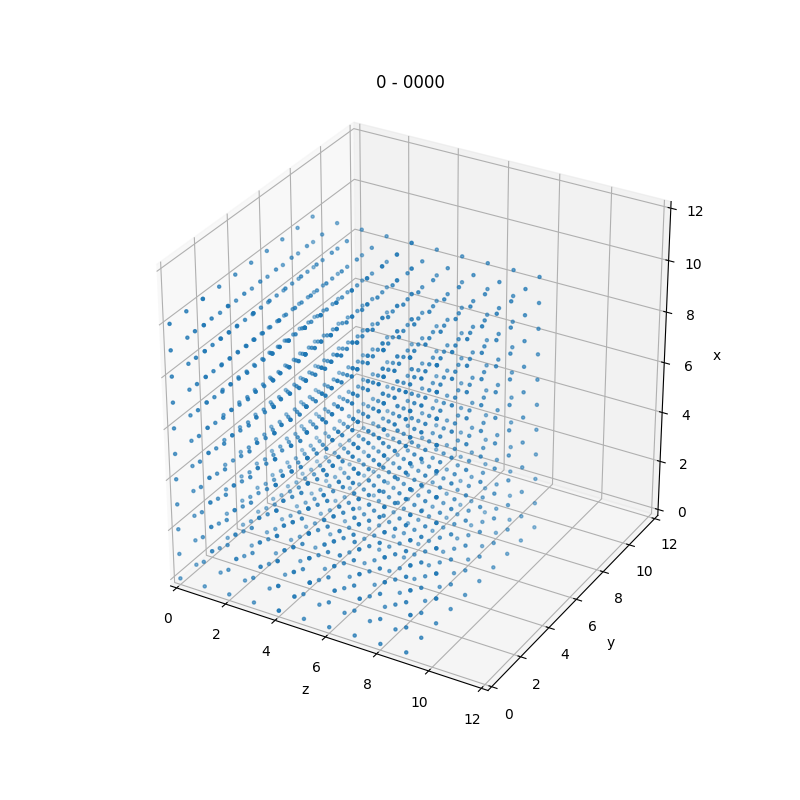

Generating 5790 particles of dimensions 10x10x10...


KeyboardInterrupt: 

In [24]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
plt.show()

suffix = formatSuffix(suffix)    
# get tomogram to pull subtomograms from
tomogram = getTomo(tomoFile)
dim = tomogram.shape
ext = os.path.splitext(tomoFile)[1]
# save info in "particles" directory, under another directory based on the name of the tomogram it was derived from
particleDir = os.path.dirname(tomoFile).replace("tomograms","particles")
saveDir = os.path.join(particleDir,os.path.basename(tomoFile).replace(ext,""))
if not os.path.exists(saveDir):
    os.makedirs(saveDir)
# set up for particle generation
particlesN = 0
rList = np.linspace(rIn+stDim/2,rOut-stDim/2,rN)
thetaList = np.arange(0,2*math.pi,2*math.pi/thetaN)
filLength = np.zeros(len(filaments))
for filIdx,filament in enumerate(filaments):
    # segmentations are as x,y,z but tomograms are z,y,x so swap values
    for i in filament:
        i[0],i[2]=i[2],i[0]
    # get total length of filament
    for start, end in list(zip(filament[0:-1],filament[1:])):
        filLength[filIdx] += np.linalg.norm(end-start)
    particlesN += int((filLength[filIdx]/axisStep+1))*rList.size*thetaList.size
powTen = (int(math.log(particlesN,10))+1)
print("Generating {:d} particles of dimensions {:d}x{:d}x{:d}...".format(particlesN,stDim,stDim,stDim))
# traverse filament and generate particles
particle = 0
for filIdx, filament in enumerate(filaments):
    axisList = np.arange(0,filLength[filIdx],axisStep)
    # initialize segment counters
    segments = list(zip(filament[0:-1],filament[1:]))
    segLengthCovered = 0
    # get first segment
    segIdx = 0
    start, end = segments[segIdx]
    # get segment length
    segLength = np.linalg.norm(end-start)
    # go along axisPos, checking which segment the axisPos is at
    for axisPos in axisList:
        # if axisPos is past the current segment, then update which segment is being traced
        if (axisPos-segLengthCovered) > segLength:
            # update segment info
            segLengthCovered += segLength
            # get next segment
            segIdx += 1
            start, end = segments[segIdx]
            # get new segment length
            segLength = np.linalg.norm(end-start)
        # unitVec1 is parallel to the axis formed by the segments
        unitVec1 = (end-start)/segLength
        # at given r
        for r in rList:
            # create a second vector perpendicular to the segment filament vector, pointing radially from axis
            # arbitrarily define theta = 0 as where x of the second vector = 0
            unitVec2 = np.array([1, -unitVec1[0]/unitVec1[1],0])
            unitVec2 = unitVec2/np.linalg.norm(unitVec2)
            # at given theta
            for theta in thetaList:
                # rotate unitVec2 by theta about unitVec1 as the axis
                unitVec2Rotated = np.dot(np.cos(theta),unitVec2)+np.dot(np.sin(theta),np.cross(unitVec1, unitVec2))
                # obtain centerpoint of subtomogram
                center = (start+unitVec1*(axisPos-segLengthCovered)+unitVec2Rotated*r).astype(int)
                # get third unit vector perpendicular to unitVec1 and unitVec2
                unitVec3 = np.cross(unitVec1, unitVec2Rotated)
                # get pixels within the dimensions of the subtomogram
                stepList = np.arange(-stDim/2,stDim/2,0.93)
                coords = np.zeros([stepList.size,stepList.size,stepList.size,3])
                for i,x in enumerate(stepList):
                    for j,y in enumerate(stepList):
                        for k,z in enumerate(stepList):
                            coords[i,j,k,:] = center + unitVec1*x + unitVec2Rotated*y + unitVec3*z
                coords = np.reshape(coords,[pow(stepList.size,3),3])
                # remove invalid coordinates
                coords = coords[(coords[:,0]<dim[0])&(coords[:,1]<dim[1])&(coords[:,2]<dim[2])&np.all(coords>0,axis=1)]
                # coords rotated so that unitVec3 is parallel to z
                rotMatrixToZ = genRotMatrix([1,0,0],unitVec3)
                coordsRotated = (rotMatrixToZ.dot(coords.T)).T
                unitVec1Rotated = rotMatrixToZ.dot(unitVec1.T).T
                # coords rotated so that the rotated unitVec1 is parallel to x
                rotMatrixToY = genRotMatrix([0,0,1],unitVec1Rotated)
                coordsRotated = (rotMatrixToY.dot(coordsRotated.T)).T
                # remove duplicate combinations of original with rotated coordinate pair, pairs
                coords = np.unique(np.append(coords,coordsRotated,axis=1).astype(int),axis=0)                    
                coords[:,3:6] = coords[:,3:6]-coords[:,3:6].min(axis=0)

                ax.cla()
                ax.scatter3D(coords[:,3],coords[:,4],coords[:,5], marker=".")
                ax.axes.set_xlabel("z")
                ax.axes.set_ylabel("y")
                ax.axes.set_zlabel("x")
                ax.axes.set_xlim3d(left=0, right=stDim+2) 
                ax.axes.set_ylim3d(bottom=0, top=stDim+2) 
                ax.axes.set_zlim3d(bottom=0, top=stDim+2)
                ax.set_box_aspect([1,1,1])
                plt.title(("{:d} - {:04d}").format(filIdx,particle))
                time.sleep(0.01)
                fig.canvas.draw()
                fig.canvas.flush_events()
                
                             
                             
#                 # create subtomogram
#                 subtomogramDim = coords[:,3:6].max(axis=0).astype(int)+1
#                 image = np.zeros(subtomogramDim)             
#                 for i in range(coords.shape[0]):
#                     image[coords[i,3],coords[i,4],coords[i,5]] = tomogram[coords[i,0],coords[i,1],coords[i,2]]             

<function matplotlib.pyplot.show(close=None, block=None)>

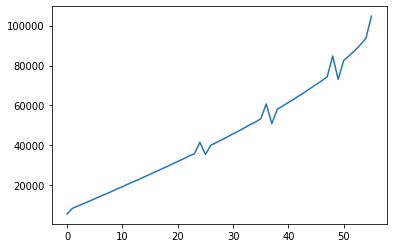

In [449]:
x = []
for r in range(56):
    n = df_idx[df_idx['r']==r].shape[0]
#     print("%6d\t\t%d\t\t%6.02f%%" % (r,n,n*100/(1087*792)))
#     print(n)
    x.append(n)
    
fig = plt.figure()
ax = plt.axes()
ax.plot(list(range(56)),x)
plt.show

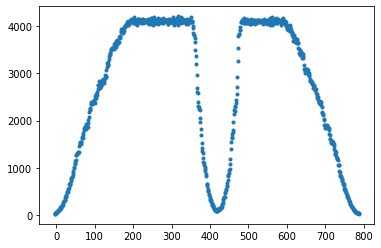

In [345]:
dfIdx['axisPos'].value_counts().plot(style='.')
plt.show()

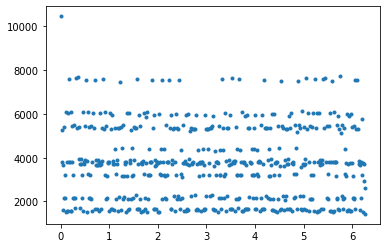

In [348]:
df['theta'].value_counts().plot(style='.')
plt.show()

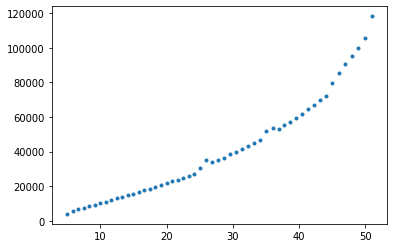

In [349]:
df['r'].value_counts().plot(style='.')
plt.show()